In [250]:
import torch
import torch.nn

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

from model import TransformerEnc
from data import create_dataloaders, MuscleDataset

In [287]:
model_fn = 'checkpoints/overlapping_finetuning_10kg/best_model.pth'

In [289]:
device = torch.device('mps')

In [290]:
checkpoint = torch.load(model_fn, map_location=device)
model_dict = checkpoint['model']
optimizer_dict = checkpoint['optimizer']
scheduler_dict = checkpoint['lr_scheduler']

In [291]:
model_args = {
            'dim_model': 128,
            'num_heads': 16,
            'num_encoder_layers': 8,
            'dropout_p': float(0.1),
            'device': device
            }

In [136]:
for key in list(model_dict.keys()):
    model_dict[key[7:]] = model_dict.pop(key)

In [292]:
model = TransformerEnc(**model_args).to(device)
print(model)
model.load_state_dict(model_dict)

TransformerEnc(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (conv1): Conv2d(1, 126, kernel_size=(51, 9), stride=(1, 1), padding=(0, 4))
  (relu): ReLU()
  (tanh): Tanh()
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer0): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEn

<All keys matched successfully>

In [293]:
dataset_args = {'percent': 1.0,
                'step': 30,
                'cond': 'True'}

valid_dataset = MuscleDataset(dataset_path='dataset/datasetsplits/val.txt', weight='10kg',
                              logger=None, phase='val', **dataset_args)
train_dataset = MuscleDataset(dataset_path='dataset/datasetsplits/train.txt', # weight='5kg',
                              logger=None, phase='val', **dataset_args)

File count: 783
File count: 11153


torch.Size([1, 8, 30])


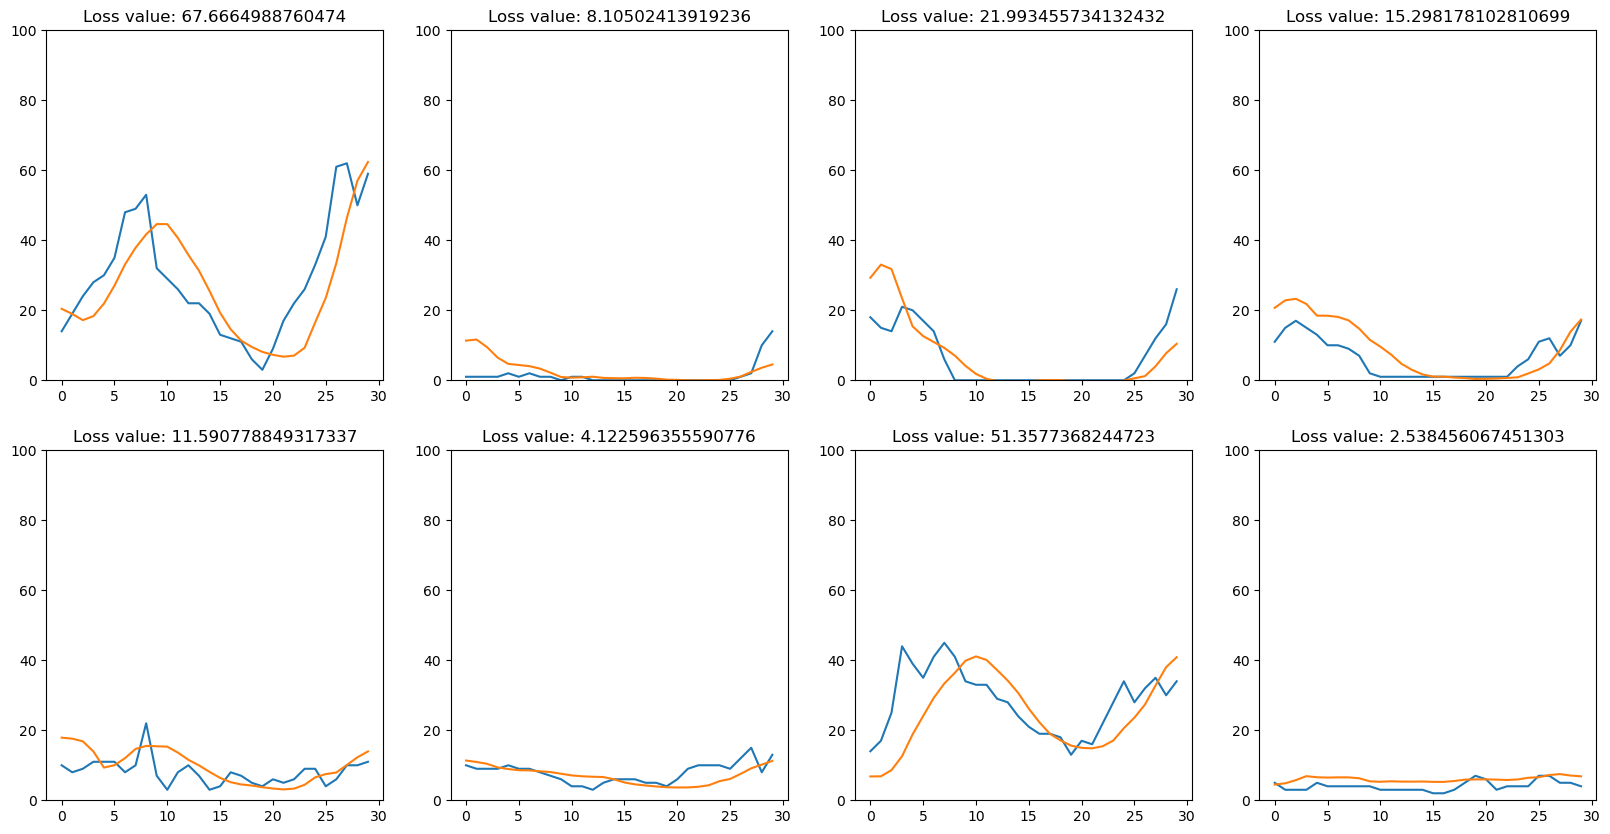

In [311]:
def test(model, dataset, data_idx, device):
    src = torch.Tensor(dataset[data_idx]['3dskeleton']).unsqueeze(0)
    src = src.reshape(src.shape[0], src.shape[1], -1)
    
    condval = torch.Tensor(dataset[data_idx]['condval'])
    
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        src, condval = src.to(device), condval.to(device)
        emg_pred = model(src, condval).cpu()
        
    muscle_id = 0
    print(emg_pred.shape)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    for i in range(2):
        for j in range(4):
            ax = axes[i, j]
            try:
                y = dataset[data_idx]['emg_values'][muscle_id, :]
                y_hat = emg_pred[0, muscle_id, :]
            except:
                y = dataset[data_idx]['emg_values']
                y_hat = emg_pred[0, 0, :]
            ax.plot(y)
            ax.plot(y_hat)
            ax.set_title(f'Loss value: {(((y - y_hat.numpy()) ** 2) ** 1/2).mean()}')
            ax.set_ylim([0, 100])
            
            muscle_id += 1

test(model, valid_dataset, random.randint(0, len(valid_dataset)), 'mps')

---

[]

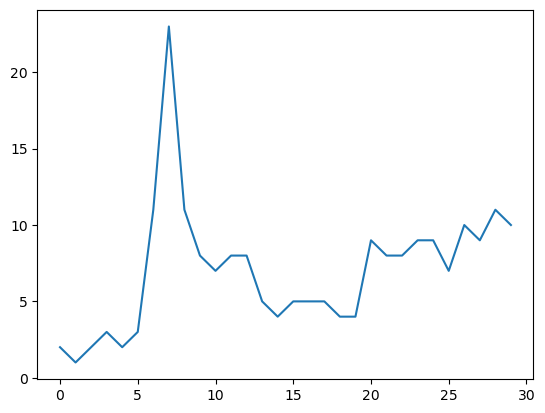

In [69]:
plt.plot(valid_dataset[1]['emg_values'])
plt.plot()

In [64]:
def limb(x, y, i, j):
    plt.plot([x[i], x[j]], [y[i], y[j]])

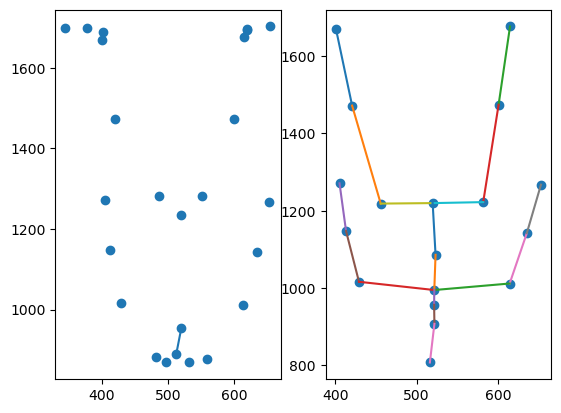

In [119]:
import numpy as np

x = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints2d.npy')[0, :25, 0]
y = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints2d.npy')[0, :25, 1]

x_ = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints2d.npy')[0, 25:, 0]
y_ = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints2d.npy')[0, 25:, 1]

plt.subplot(121)
plt.scatter(x, y)
plt.plot([x[0], x[1]], [y[0], y[1]])

plt.subplot(122)
plt.scatter(x_[:18], y_[:18])
plt.plot([x_[0], x_[1]], [y_[0], y_[1]])
plt.plot([x_[1], x_[2]], [y_[1], y_[2]])
plt.plot([x_[4], x_[5]], [y_[4], y_[5]])
plt.plot([x_[3], x_[4]], [y_[3], y_[4]])
limb(x_, y_, 6, 7)
limb(x_, y_, 7, 8)
limb(x_, y_, 9, 10)
limb(x_, y_, 10, 11)
limb(x_, y_, 2, 14)
limb(x_, y_, 14, 3)
limb(x_, y_, 14, 16)
limb(x_, y_, 15, 16)
limb(x_, y_, 15, 9)
limb(x_, y_, 15, 8)
limb(x_, y_, 15, 12)
limb(x_, y_, 12, 17)
limb(x_, y_, 17, 13)

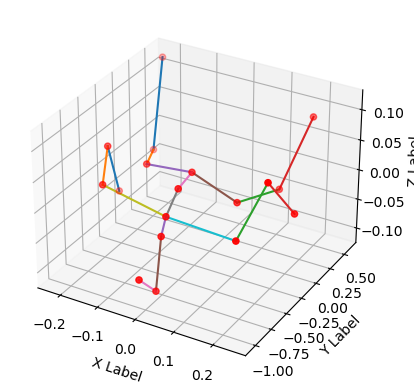

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D 데이터를 생성
np.random.seed(0)
x = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[0, 25:43, 0]
y = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[0, 25:43, 1]
z = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[0, 25:43, 2]

limbs = [[0, 1], [1, 2], [3, 4], [4, 5], [2, 14], [3, 14], [14, 16], [15, 16], [15, 8], [15, 9], [6, 7], [7, 8], [9, 10], [10, 11], [12, 15], [12, 17], [17, 13]]

# 3D 산점도 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 산점도 그리기
ax.scatter(x, y, z, c='r', marker='o')
for l in limbs:
    ax.plot([x[l[0]], x[l[1]]], [y[l[0]], y[l[1]]], [z[l[0]], z[l[1]]])

# 축 이름 설정
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 그래프 보여주기
plt.show()

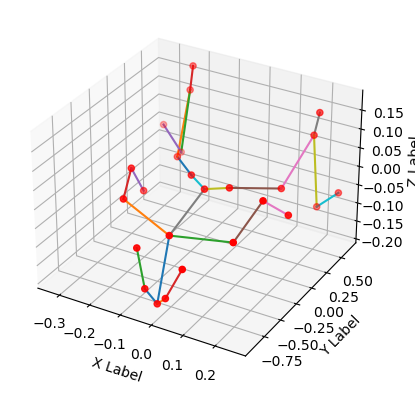

In [177]:
# 3D 데이터를 생성
np.random.seed(0)
x = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[0, :25, 0]
y = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[0, :25, 1]
z = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[0, :25, 2]

limbs = [[0, 1], [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 12], [8, 9], [9, 10], [10, 11], [11, 22], [11, 24], [22, 23], [12, 13], [13, 14], [14, 21], [14, 19], [19, 20], [0, 15], [0, 16], [15, 17], [16, 18]]

# 3D 산점도 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 산점도 그리기
ax.scatter(x, y, z, c='r', marker='o')
for l in limbs:
    ax.plot([x[l[0]], x[l[1]]], [y[l[0]], y[l[1]]], [z[l[0]], z[l[1]]])

# 축 이름 설정
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 그래프 보여주기
plt.show()

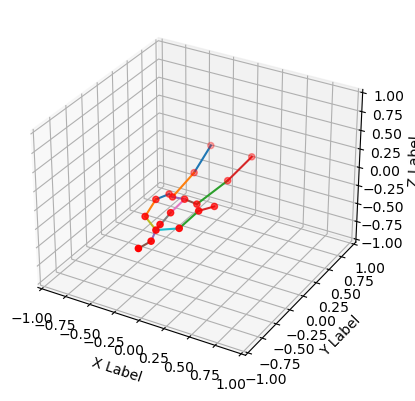

In [177]:
def exchange_15_17(arr):
    arr_flat = arr.flatten()
    arr_flat[15], arr_flat[17] = arr_flat[17], arr_flat[15]

    return arr_flat.reshape(18,)

x = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[5, 25:43, 0]
y = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[5, 25:43, 1]
z = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/170/joints3d.npy')[5, 25:43, 2]

x_ = exchange_15_17(x)
y_ = exchange_15_17(y)
z_ = exchange_15_17(z)

limbs = [[0, 1], [1, 2], [3, 4], [4, 5], [2, 14], [3, 14], [14, 16], [12, 16], [12, 8], [12, 9], [6, 7], [7, 8], [9, 10], [10, 11], [12, 15], [15, 13]]

# 3D 산점도 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# 산점도 그리기
ax.scatter(x, y, z, c='r', marker='o')
for l in limbs:
    ax.plot([x_[l[0]], x_[l[1]]], [y_[l[0]], y_[l[1]]], [z_[l[0]], z_[l[1]]])

# 축 이름 설정
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 그래프 보여주기
plt.show()

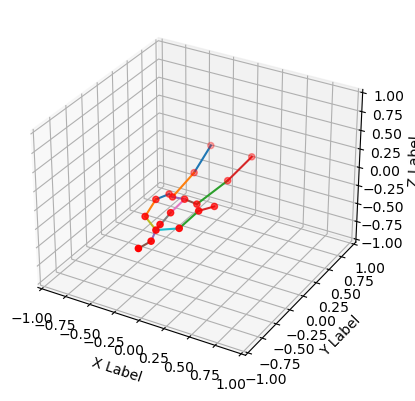

In [178]:
def exchange_15_17(arr):
    arr_flat = arr.flatten()
    arr_flat[15], arr_flat[17] = arr_flat[17], arr_flat[15]

    return arr_flat.reshape(18,)

x = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/171/joints3d.npy')[0, 25:43, 0]
y = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/171/joints3d.npy')[0, 25:43, 1]
z = np.load('/Users/mesrwi/kitech/musclesinaction/musclesinaction/MIADatasetOfficial/val/Subject0/ElbowPunch/171/joints3d.npy')[0, 25:43, 2]

x_ = exchange_15_17(x)
y_ = exchange_15_17(y)
z_ = exchange_15_17(z)

limbs = [[0, 1], [1, 2], [3, 4], [4, 5], [2, 14], [3, 14], [14, 16], [12, 16], [12, 8], [12, 9], [6, 7], [7, 8], [9, 10], [10, 11], [12, 15], [15, 13]]

# 3D 산점도 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# 산점도 그리기
ax.scatter(x, y, z, c='r', marker='o')
for l in limbs:
    ax.plot([x_[l[0]], x_[l[1]]], [y_[l[0]], y_[l[1]]], [z_[l[0]], z_[l[1]]])

# 축 이름 설정
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 그래프 보여주기
plt.show()

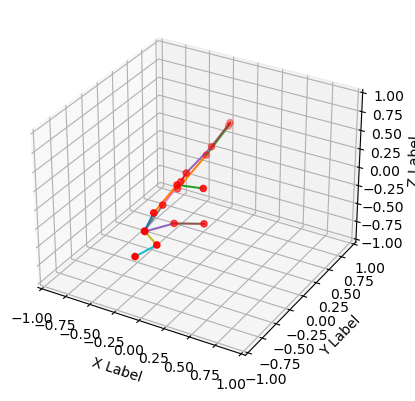

In [182]:
def exchange_15_17(arr):
    arr_flat = arr.flatten()
    arr_flat[15], arr_flat[17] = arr_flat[17], arr_flat[15]

    return arr_flat.reshape(18,)

x = np.load('/Users/mesrwi/kitech/project_skl/mia_transformer/dataset/chunk/Subject0/10kg_top/15/3d_skeleton.npy')[0, :, 0]
y = np.load('/Users/mesrwi/kitech/project_skl/mia_transformer/dataset/chunk/Subject0/10kg_top/15/3d_skeleton.npy')[0, :, 1]
z =  np.load('/Users/mesrwi/kitech/project_skl/mia_transformer/dataset/chunk/Subject0/10kg_top/15/3d_skeleton.npy')[0, :, 2]

limbs = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8], [8, 9], [9, 10], [8, 11], [11, 12], [12, 13], [8, 14], [14, 15], [15, 16]]

# 3D 산점도 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# 산점도 그리기
ax.scatter(x, y, z, c='r', marker='o')
for l in limbs:
    ax.plot([x[l[0]], x[l[1]]], [y[l[0]], y[l[1]]], [z[l[0]], z[l[1]]])

# 축 이름 설정
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 그래프 보여주기
plt.show()